# Grid Navigation using Sarsa and Q-learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from grid_world import Grid as Grid

## Helper functions

In [2]:
def random_argmax(arr):
    # Find all indices of the maximum value in the array
    max_indices = np.flatnonzero(arr == np.max(arr))
    # Randomly select one index among the maximums
    return np.random.choice(max_indices)


def epsilon_greedy(q_values, epsilon, grid):
    # With probability (1 - epsilon), choose the greedy action
    if np.random.rand() > epsilon:
        return random_argmax(q_values)
    else:
        # Otherwise choose a random action
        return np.random.choice([i for i in range(grid.number_of_actions)])


def derive_policy(discount, value_fn, grid):
    # Initialize policy with one default action per state
    policy = [[0] for _ in range(grid.number_of_states)]

    # Loop through each state in the environment
    for state in range(grid.number_of_states):
        q_estimates = []  # List to store Q values for each action

        # Loop through each possible action
        for action in range(grid.number_of_actions):
            expected_value = 0

            # Calculate expected value using transition model
            for prob, next_state, reward, _ in grid.model[state][action]:
                expected_value += prob * (reward + discount * value_fn[next_state])

            q_estimates.append(expected_value)  # Store result for the action

        # Select indices of all actions that yield the max expected value
        best_actions = np.unique(np.argwhere(q_estimates == np.max(q_estimates)))
        policy[state] = best_actions.tolist()

    return policy


def render_policy(opt_policy, grid):
    # Initialize visual output with empty strings
    display = ['' for _ in range(grid.number_of_states)]

    # Loop over each state
    for state in range(grid.number_of_states):
        num_actions = len(opt_policy[state])

        if num_actions == 4:
            display[state] += 'o'  # 'o' for all directions available
        else:
            # Add arrow(s) corresponding to action(s)
            for act in range(num_actions):
                display[state] += grid.action_text[opt_policy[state][act]]

    return display


def render_trajectory(opt_policy, grid):
    # Initialize trajectory display with empty spaces
    path = [' ' for _ in range(grid.number_of_states)]
    current_state = grid.state_0

    # Limit trajectory to 100 steps to avoid infinite loops
    for _ in range(100):
        # Mark current state with arrow indicating chosen action
        path[current_state] = grid.action_text[opt_policy[current_state][0]]

        # Follow the model transition for the chosen action
        _, next_state, _, is_terminal = grid.model[current_state][opt_policy[current_state][0]][0]

        current_state = next_state  # Update state

        if is_terminal:
            path[current_state] = 'x'  # Mark terminal state with 'x'
            break

    return path

"""
Computes the optimal policy given a value function using policy improvement.

Args:
    gamma (float): Discount factor for future rewards (0 ≤ gamma ≤ 1)
    V (ndarray): Current value function array of shape (number_of_states,)
    env (object): Environment containing:
        - number_of_states (int): Total number of states
        - number_of_actions (int): Number of possible actions
        - model (ndarray): Transition model array of shape 
                         (number_of_states, number_of_actions, n, 3) where:
                         [..., 0]: p - Transition probability (∑p = 1)
                         [..., 1]: s_ - Next state index
                         [..., 2]: r - Immediate reward

Returns:
    list: Optimal policy where each element is a list of optimal actions for that state.
          Format: [state][action_indices] where action_indices may contain multiple
          equally-good actions.
"""
def find_policy(gamma, V, env):
    pol = [[0] for _ in range(env.number_of_states)]  # initialize a deterministic policy

    for s in range(env.number_of_states):  # iterate through all the states in the state space
        temp1 = []
        for a in range(env.number_of_actions):  # iterate through all the actions in the action space
            temp2 = 0
            for p, s_, r in env.model[s][a]:  # iterate through all the possibilities in model
                temp2 += p * (r + gamma * V[s_])
            temp1.append(temp2)
                
        pol[s] = (np.unique(np.argwhere(temp1 == np.max(temp1)))).tolist()  # find the optimal policy under the current value function
        
    return pol

"""
    Plots a 5x5 grid with centered symbols, colored overlays on specific cells.
    (0,0) is top-left. Colors: (0,1)=blue, (0,4)=green, (4,2)=red, (4,4)=yellow.
"""

def plot_symbolic_policy_from_symbols(symbol_grid, title="Optimal Policy"):
    N = 5  # Force 5x5 grid
    assert symbol_grid.shape == (N, N), "Symbol grid must be 5x5"

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Configure grid lines
    ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_xticks(np.arange(N))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(N))  # x-axis labels 0-4 (bottom)
    ax.set_yticklabels(np.arange(N))  # y-axis labels 0-4 (left)
    
    # Grid styling
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)
    ax.grid(which='major', alpha=0)
    ax.tick_params(axis='both', which='both', length=0)

    # Add colored overlays (semi-transparent)
    overlay_cells = [
        ((4, 0), 'blue', 0.3),
        ((2, 0), 'red', 0.3),
        ((2, 1), 'red', 0.3),
        ((2, 3), 'red', 0.3),
        ((2, 4), 'red', 0.3),
        ((0, 0), 'gray', 0.3),
        ((0, 4), 'gray', 0.3)
    ]
    for (y, x), color, alpha in overlay_cells:
        ax.add_patch(Rectangle(
            (x - 0.5, y - 0.5), 1, 1,  # (x,y) of bottom-left corner, width, height
            facecolor=color, alpha=alpha, edgecolor='none'
        ))

    # Plot symbols (centered)
    for i in range(N):
        for j in range(N):
            ax.text(j, i, symbol_grid[i, j], 
                   ha='center', va='center', 
                   fontsize=16, zorder=3)  # zorder ensures text is above patches

    # Grey border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('grey')
        spine.set_linewidth(1)

    ax.invert_yaxis()  # (0,0) at top-left
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"figures/{title}.png", dpi=300, bbox_inches='tight')
    plt.show()

"""
Converts a deterministic policy into a human-readable format with arrow symbols.

Args:
    policy (list): Deterministic policy array where each element represents
                 the chosen action index for a state (length = number_of_states)
    env (object): Environment containing:
        - number_of_states (int): Total number of states in the gridworld
        - action_text (list): Unicode arrow symbols corresponding to actions:
                            ['←', '↓', '→', '↑']  # Left, Down, Right, Up

Returns:
    list: Visualized policy array where each action index is replaced with
          its corresponding arrow symbol (length = number_of_states)
"""
def print_policy(policy, env):
    policy_visual = ['' for _ in range(env.number_of_states)]

    for s in range(env.number_of_states):
        lenth = len(policy[s])
        if lenth == 4:
            policy_visual[s] += 'o'  # 'o' means 4 directions are all available
        else:
            for a in range(lenth):
                policy_visual[s] += env.action_text[policy[s][a]]

    return policy_visual


## Sarsa

In [3]:
def run_sarsa(num_episodes, discount_factor, eps, learning_rate, grid):
    # Initialize policy as a list of default actions for each state
    learned_policy = [[0] for _ in range(grid.number_of_states)]

    # Initialize Q-table: one Q-value per (state, action) pair
    q_table = [[0 for _ in range(grid.number_of_actions)] for _ in range(grid.number_of_states)]

    # Track the maximum Q-value per state (for visualization or evaluation)
    best_q_values = [0 for _ in range(grid.number_of_states)]

    # Track the total reward per episode
    episode_rewards = [0 for _ in range(num_episodes)]

    # Iterate through each episode
    for episode in range(num_episodes):
        # Start from the initial state
        current_state = grid.state_0

        # Select initial action using epsilon-greedy strategy
        current_action = epsilon_greedy(q_table[current_state], eps, grid)

        # Initialize cumulative reward for this episode
        total_reward = 0

        # Start the interaction loop
        while True:
            # Sample the environment response (always the first transition)
            _, next_state, reward, is_terminal = grid.model[current_state][current_action][0]

            # Select the next action using epsilon-greedy strategy
            next_action = epsilon_greedy(q_table[next_state], eps, grid)

            # Update the Q-value using the SARSA update rule
            q_table[current_state][current_action] += learning_rate * (
                reward + discount_factor * q_table[next_state][next_action] - q_table[current_state][current_action]
            )

            # Transition to the next state and action
            current_state, current_action = next_state, next_action

            # Accumulate the reward
            total_reward += reward

            # Break if terminal state is reached
            if is_terminal:
                break

        # Log the total reward for this episode
        episode_rewards[episode] = total_reward

    # After learning, derive the optimal policy
    for state in range(grid.number_of_states):
        # Find all actions with the highest Q-value in this state
        best_actions = np.unique(np.argwhere(q_table[state] == np.max(q_table[state]))).tolist()
        learned_policy[state] = best_actions

    # Extract the best Q-value for each state (max across actions)
    best_q_values = np.max(q_table, axis=1)

    return q_table, best_q_values, learned_policy, episode_rewards


## Q-learning

In [4]:
def run_q_learning(num_episodes, discount, eps, lr, grid):
    # Initialize the optimal policy as a list of default actions (one per state)
    learned_policy = [[0] for _ in range(grid.number_of_states)]

    # Initialize the Q-table with zeros for each (state, action) pair
    q_values = [[0 for _ in range(grid.number_of_actions)] for _ in range(grid.number_of_states)]

    # This will hold the maximum Q-value for each state (for reference)
    max_q_per_state = [0 for _ in range(grid.number_of_states)]

    # Track the cumulative reward received in each episode
    episode_returns = [0 for _ in range(num_episodes)]

    # Iterate over all episodes
    for episode in range(num_episodes):
        # Start from the initial state
        current_state = grid.state_0
        total_reward = 0

        # Repeat until terminal state is reached
        while True:
            # Choose an action using epsilon-greedy strategy
            action = epsilon_greedy(q_values[current_state], eps, grid)

            # Sample the transition from the model: (prob, next_state, reward, terminal)
            _, next_state, reward, done = grid.model[current_state][action][0]

            # Get the max Q-value of the next state (off-policy)
            best_future_q = np.max(q_values[next_state])

            # Update Q-value using the Q-learning update rule
            q_values[current_state][action] += lr * (
                reward + discount * best_future_q - q_values[current_state][action]
            )

            # Transition to the next state
            current_state = next_state

            # Accumulate reward for this episode
            total_reward += reward

            # If terminal state is reached, stop this episode
            if done:
                break

        # Store the total reward for the current episode
        episode_returns[episode] = total_reward

    # Derive the optimal policy from the learned Q-table
    for state in range(grid.number_of_states):
        # Choose all actions that give the maximum Q-value in this state
        best_actions = np.unique(np.argwhere(q_values[state] == np.max(q_values[state]))).tolist()
        learned_policy[state] = best_actions

    # Store the maximum Q-value for each state
    max_q_per_state = np.max(q_values, axis=1)

    return q_values, max_q_per_state, learned_policy, episode_returns


In [5]:
# Initialize parameters
max_ep = 10000
# Discount factor, epsilon, and learning rate
gam = 0.99
eps = 0.2
alp = 0.5
Env = Grid()

# Optimal policies and Q-values using SARSA and Q-learning
Q_1, Q_opt_1, pol_opt_1, reward_plot_1 = run_sarsa(max_ep, gam, eps, alp, Env)
Q_2, Q_opt_2, pol_opt_2, reward_plot_2 = run_q_learning(max_ep, gam, eps, alp, Env)

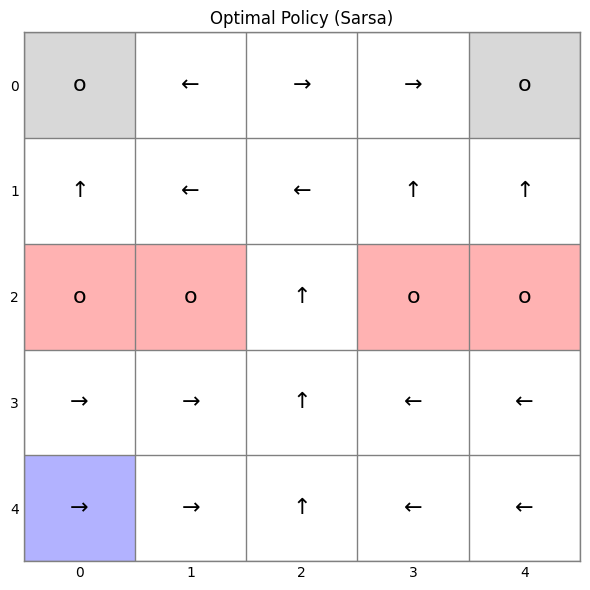

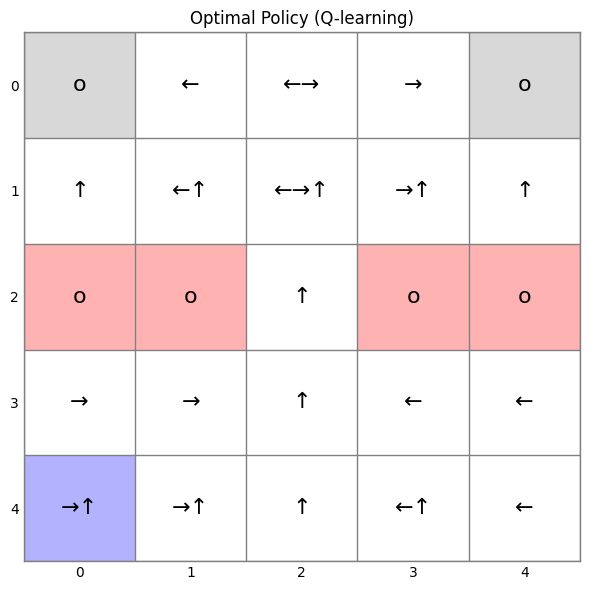

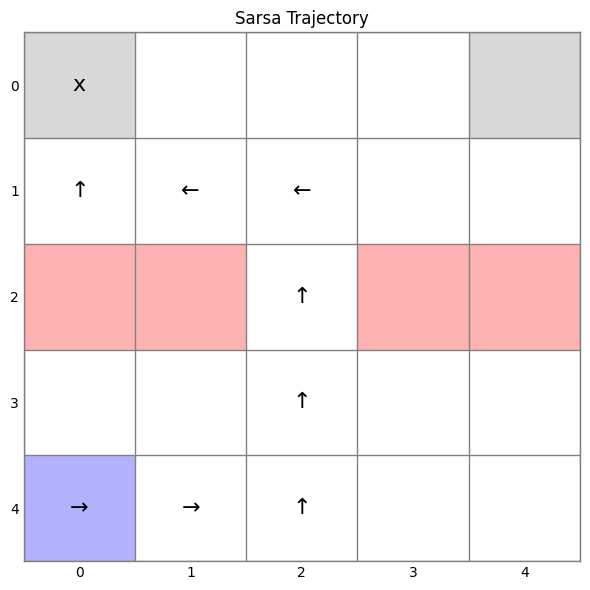

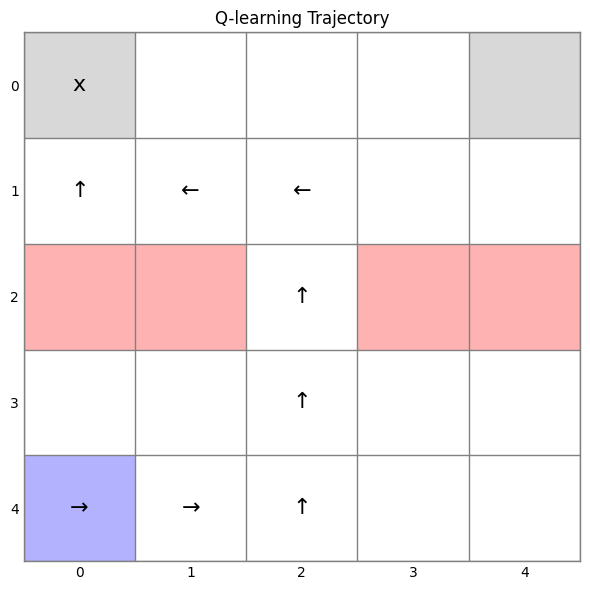

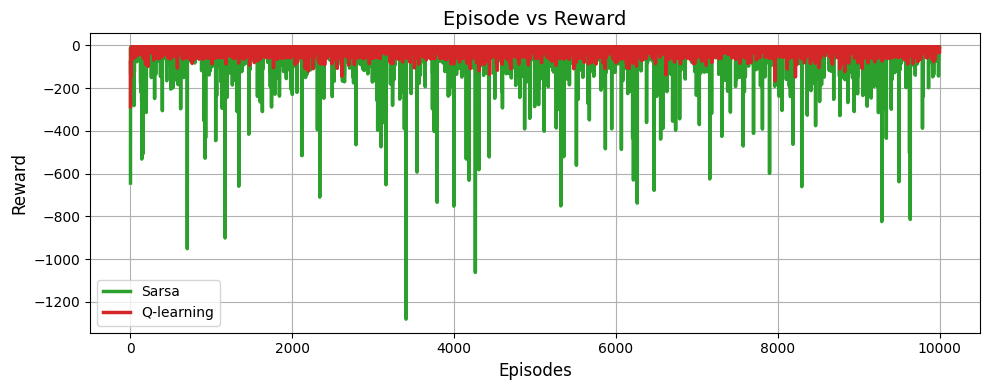

In [6]:
# Visualize the optimal policies and trajectories
N = Env.number_of_rows

# Convert policies to symbolic representation for visualization
policy_symbols_1 = np.array(print_policy(pol_opt_1, Env)).reshape(N, N)
# Plot the symbolic policy for Sarsa
plot_symbolic_policy_from_symbols(policy_symbols_1, title="Optimal Policy (Sarsa)")

# Convert policies to symbolic representation for Q-learning
policy_symbols_2 = np.array(print_policy(pol_opt_2, Env)).reshape(N, N)
# Plot the symbolic policy for Q-learning
plot_symbolic_policy_from_symbols(policy_symbols_2, title="Optimal Policy (Q-learning)")

# Render trajectories for both policies
trajectory_symbols_1 = np.array(render_trajectory(pol_opt_1, Env)).reshape(N, N)
# Plot the symbolic policy for Sarsa trajectory
plot_symbolic_policy_from_symbols(trajectory_symbols_1, title="Sarsa Trajectory")

# Render trajectory for Q-learning policy
trajectory_symbols_2 = np.array(render_trajectory(pol_opt_2, Env)).reshape(N, N)
# Plot the symbolic policy for Q-learning trajectory
plot_symbolic_policy_from_symbols(trajectory_symbols_2, title="Q-learning Trajectory")

# Plotting the rewards over episodes for both algorithms
fig1 = plt.figure(figsize=(10, 4))
plt.plot(range(1, max_ep + 1), reward_plot_1, label="Sarsa", color='#2ca02c', linewidth=2.5)
plt.plot(range(1, max_ep + 1), reward_plot_2, label="Q-learning", color='#d62728', linewidth=2.5)
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Episode vs Reward", fontsize=14)
plt.tight_layout()
plt.savefig("figures/reward_plot.png", dpi=300, bbox_inches='tight')
plt.show()